<a href="https://colab.research.google.com/github/nhwie1705/nlp/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
!pip install torch==2.3.1 torchtext==0.18.0 torchdata==0.7.1
!pip install spacy

!python -m spacy download en_core_web_sm
!python -m spacy download fr_core_news_sm

print("\nHoàn tất")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 100.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.3/16.3 MB 124.2 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('fr_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.

Hoàn tất


In [32]:
from google.colab import drive
import os

try:
  drive.mount('/content/drive', force_remount=True)
except ValueError:
  print("Lỗi mount, hãy reset .")

root_folder = '/content/drive/MyDrive/NLP'
data_folder = os.path.join(root_folder, 'data')
model_folder = os.path.join(root_folder, 'models')
result_folder = os.path.join(root_folder, 'results')

os.makedirs(data_folder, exist_ok=True)
os.makedirs(model_folder, exist_ok=True)
os.makedirs(result_folder, exist_ok=True)

print(f"Đã tạo folder {data_folder}")
print(f"Đã tạo folder {model_folder}")
print(f"Đã tạo folder {result_folder}")

Mounted at /content/drive
Đã tạo folder /content/drive/MyDrive/NLP/data
Đã tạo folder /content/drive/MyDrive/NLP/models
Đã tạo folder /content/drive/MyDrive/NLP/results


In [33]:
import requests
import gzip
import shutil
import io
import os

#tải dữ liệu raw
file_map = {
  "train.en": "https://raw.githubusercontent.com/multi30k/dataset/master/data/task1/raw/train.en.gz",
  "train.fr": "https://raw.githubusercontent.com/multi30k/dataset/master/data/task1/raw/train.fr.gz",
  "val.en":   "https://raw.githubusercontent.com/multi30k/dataset/master/data/task1/raw/val.en.gz",
  "val.fr":   "https://raw.githubusercontent.com/multi30k/dataset/master/data/task1/raw/val.fr.gz",
  "test.en":  "https://raw.githubusercontent.com/multi30k/dataset/master/data/task1/raw/test_2016_flickr.en.gz",
  "test.fr":  "https://raw.githubusercontent.com/multi30k/dataset/master/data/task1/raw/test_2016_flickr.fr.gz"
}

def download_and_extract(url, save_path):
  print(f"Đang tải {save_path}...", end=" ")

  try:
    r = requests.get(url)
    if r.status_code != 200:
      print(f"Lỗi tại (Code {r.status_code})")
      return
    #giải nén
    with gzip.open(io.BytesIO(r.content), 'rb') as f_in:
      with open(save_path, 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)

    dest_path = os.path.join(data_folder, save_path)
    shutil.copy(save_path, dest_path)

    size = os.path.getsize(save_path)
    print(f"{size/1024:.1f} KB")

  except Exception as e:
    print(f"Lỗi: {e}")

#lưu dữ liệu vào folder data
print(f"\nĐang tải và lưu dữ liệu vào: {data_folder}")
for filename, url in file_map.items():
    download_and_extract(url, filename)


Đang tải và lưu dữ liệu vào: /content/drive/MyDrive/NLP/data
Đang tải train.en... 1759.0 KB
Đang tải train.fr... 2061.8 KB
Đang tải val.en... 61.8 KB
Đang tải val.fr... 72.2 KB
Đang tải test.en... 60.6 KB
Đang tải test.fr... 70.6 KB


In [34]:
import torch
import spacy
from torchtext.vocab import build_vocab_from_iterator
import csv
import os

try:
  spacy_en = spacy.load("en_core_web_sm")
  spacy_fr = spacy.load("fr_core_news_sm")
except OSError:
  os.system("python -m spacy download en_core_web_sm")
  os.system("python -m spacy download fr_core_news_sm")
  spacy_en = spacy.load("en_core_web_sm")
  spacy_fr = spacy.load("fr_core_news_sm")

def tokenize_en(text):
  return [tok.text for tok in spacy_en.tokenizer(text)]

def tokenize_fr(text):
  return [tok.text for tok in spacy_fr.tokenizer(text)]

def yield_tokens(file_path, tokenizer):
  with open(file_path, encoding='utf-8') as f:
    for line in f:
      if line.strip():
        yield tokenizer(line.strip())

special_symbols = ['<unk>', '<pad>', '<sos>', '<eos>']
UNK_IDX, PAD_IDX, SOS_IDX, EOS_IDX = 0, 1, 2, 3

print("\n--------------")
print("Đang tạo từ điển...")

vocab_en = build_vocab_from_iterator(
  yield_tokens('train.en', tokenize_en),
  min_freq=2,
  specials=special_symbols,
  max_tokens=10000
)
vocab_en.set_default_index(UNK_IDX)

vocab_fr = build_vocab_from_iterator(
  yield_tokens('train.fr', tokenize_fr),
  min_freq=2,
  specials=special_symbols,
  max_tokens=10000
)
vocab_fr.set_default_index(UNK_IDX)

print(f"Đã tạo từ điển tiếng anh với {len(vocab_en)} từ")
print(f"Đã tạo từ điển tiếng pháp với {len(vocab_fr)} từ")

vocab_save_path = os.path.join(data_folder, 'vocab.pth')

print(f"Đang lưu vào: {vocab_save_path}")
torch.save({'en': vocab_en, 'fr': vocab_fr}, vocab_save_path)
print("Lưu thành công")

def save_csv(vocab, path):
  with open(path, 'w', encoding='utf-8', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(['ID', 'Word'])
    for i, w in enumerate(vocab.get_itos()):
      writer.writerow([i, w])

save_csv(vocab_en, os.path.join(data_folder, 'vocab_en.csv'))
save_csv(vocab_fr, os.path.join(data_folder, 'vocab_fr.csv'))
print("\nHoàn tất")


--------------
Đang tạo từ điển...
Đã tạo từ điển tiếng anh với 6191 từ
Đã tạo từ điển tiếng pháp với 6555 từ
Đang lưu vào: /content/drive/MyDrive/NLP/data/vocab.pth
Lưu thành công

Hoàn tất


In [35]:
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import torch
import os

class TranslationDataset(Dataset):
  def __init__(self, path_en, path_fr, vocab_en, vocab_fr):
    self.data = []
    #xử lý đường dẫn file
    if 'data_folder' in globals():
      path_en = os.path.join(data_folder, os.path.basename(path_en))
      path_fr = os.path.join(data_folder, os.path.basename(path_fr))

    with open(path_en, 'r', encoding='utf-8') as f_en, open(path_fr, 'r', encoding='utf-8') as f_fr:
      for line_en, line_fr in zip(f_en, f_fr):
        line_en, line_fr = line_en.strip(), line_fr.strip()
        if not line_en or not line_fr: continue
        #biến chữ thành
        en_indices = [vocab_en[token] for token in tokenize_en(line_en)]
        fr_indices = [vocab_fr[token] for token in tokenize_fr(line_fr)]

        #thêm <sos>, <eos>
        en_indices = [SOS_IDX] + en_indices + [EOS_IDX]
        fr_indices = [SOS_IDX] + fr_indices + [EOS_IDX]

        self.data.append((torch.tensor(en_indices), torch.tensor(fr_indices)))

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    return self.data[idx]

def collate_fn(batch):
  #sắp xếp câu dài lên đầu
  batch.sort(key=lambda x: len(x[0]), reverse=True)
  src_batch, trg_batch = [], []
  for src_sample, trg_sample in batch:
    src_batch.append(src_sample)
    trg_batch.append(trg_sample)

  #thêm số 1 (<pad>) cho câu ngắn bằng câu dài
  src_batch = pad_sequence(src_batch, padding_value=PAD_IDX)
  trg_batch = pad_sequence(trg_batch, padding_value=PAD_IDX)
  return src_batch, trg_batch

#khởi tạo dataloader
BATCH_SIZE = 128

print("Đang đóng gói dữ liệu...")
#tạo Dataset
train_dataset = TranslationDataset('train.en', 'train.fr', vocab_en, vocab_fr)
val_dataset = TranslationDataset('val.en', 'val.fr', vocab_en, vocab_fr)

#tạo DataLoader
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

print(f"'train_loader' với {len(train_loader)} batches.")
print("\nHoàn tất")

Đang đóng gói dữ liệu...
'train_loader' với 227 batches.

Hoàn tất


In [36]:
import torch.nn as nn
import random

#Thiết lập tham số
INPUT_DIM = len(vocab_en)
OUTPUT_DIM = len(vocab_fr)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#encoder câu tiếng Anh
class Encoder(nn.Module):
 def __init__(self, input_dim, emb_dim, hid_dim, n_layers, dropout):
  super().__init__()
  self.hid_dim = hid_dim
  self.n_layers = n_layers

  self.embedding = nn.Embedding(input_dim, emb_dim)
  #LSTM
  self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout=dropout)
  self.dropout = nn.Dropout(dropout)

 def forward(self, src):
  embedded = self.dropout(self.embedding(src))
  outputs, (hidden, cell) = self.rnn(embedded)
  return hidden, cell

#decoder sang tiếng Pháp
class Decoder(nn.Module):
  def __init__(self, output_dim, emb_dim, hid_dim, n_layers, dropout):
    super().__init__()
    self.output_dim = output_dim
    self.hid_dim = hid_dim
    self.n_layers = n_layers

    self.embedding = nn.Embedding(output_dim, emb_dim)
    self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout=dropout)
    self.fc_out = nn.Linear(hid_dim, output_dim)
    self.dropout = nn.Dropout(dropout)

  def forward(self, input, hidden, cell):
    input = input.unsqueeze(0)
    embedded = self.dropout(self.embedding(input))
    output, (hidden, cell) = self.rnn(embedded, (hidden, cell))
    prediction = self.fc_out(output.squeeze(0))
    return prediction, hidden, cell

#SEQ2SEQ
class Seq2Seq(nn.Module):
  def __init__(self, encoder, decoder, device):
    super().__init__()
    self.encoder = encoder
    self.decoder = decoder
    self.device = device

  def forward(self, src, trg, teacher_forcing_ratio=0.5):
    batch_size = src.shape[1]
    trg_len = trg.shape[0]
    trg_vocab_size = self.decoder.output_dim

    outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
    #Encoder -> Lấy Context Vector(hidden, cell)
    hidden, cell = self.encoder(src)
    #Decoder
    #Token đầu tiên đưa vào Decoder luôn là <sos>
    input = trg[0,:]

    for t in range(1, trg_len):
      #Chạy decoder bước t
      output, hidden, cell = self.decoder(input, hidden, cell)
      #Lưu dự đoán
      outputs[t] = output
      teacher_force = random.random() < teacher_forcing_ratio
      top1 = output.argmax(1)

      #nếu teacher_force = True thì dùng từ đúng (trg[t]), ngược lại dùng từ dự đoán
      input = trg[t] if teacher_force else top1

    return outputs

#khởi tạo mô hình
enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)

model = Seq2Seq(enc, dec, DEVICE).to(DEVICE)

#khởi tạo trọng số
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param.data, -0.08, 0.08)
model.apply(init_weights)

print(f"- Hidden Size: {HID_DIM}")
print(f"- Số Layers: {N_LAYERS}")
print(f"- Tổng tham số có thể huấn luyện: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")
print("\nHoàn tất")

- Hidden Size: 512
- Số Layers: 2
- Tổng tham số có thể huấn luyện: 13,982,107

Hoàn tất


In [37]:
import torch.optim as optim
import time
import math
import os

#thiết lập optimizer và loss
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)

if 'data_folder' not in globals():
  data_folder = '/content/drive/MyDrive/NLP'

root_folder = os.path.dirname(data_folder.rstrip('/'))
model_folder = os.path.join(root_folder, 'models')

#tạo nếu chưa có
if not os.path.exists(model_folder):
    os.makedirs(model_folder)

save_path = os.path.join(model_folder, 'best_model.pth')

def train(model, iterator, optimizer, criterion, clip):
  model.train()
  epoch_loss = 0
  for i, (src, trg) in enumerate(iterator):
    src, trg = src.to(DEVICE), trg.to(DEVICE)

    optimizer.zero_grad()
    output = model(src, trg)

    output_dim = output.shape[-1]
    output = output[1:].view(-1, output_dim)
    trg = trg[1:].view(-1)

    loss = criterion(output, trg)
    loss.backward()

    #clip gradient để tránh bùng nổ gradient
    torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
    optimizer.step()

    epoch_loss += loss.item()
  return epoch_loss / len(iterator)

def evaluate(model, iterator, criterion):
  model.eval()
  epoch_loss = 0
  with torch.no_grad():
    for i, (src, trg) in enumerate(iterator):
      src, trg = src.to(DEVICE), trg.to(DEVICE)
      output = model(src, trg, 0) #tắt teacher forcing
      output_dim = output.shape[-1]
      output = output[1:].view(-1, output_dim)
      trg = trg[1:].view(-1)
      loss = criterion(output, trg)
      epoch_loss += loss.item()
    return epoch_loss / len(iterator)

def epoch_time(start_time, end_time):
  elapsed_time = end_time - start_time
  elapsed_mins = int(elapsed_time / 60)
  elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
  return elapsed_mins, elapsed_secs

#train
N_EPOCHS = 20
CLIP = 1
best_valid_loss = float('inf')

#thêm biến early stopping
patience = 3
no_improve_epoch = 0
#lưu lại để vẽ loss
train_losses = []
valid_losses = []

print(f"Training {N_EPOCHS} epochs")
print(f"Checkpoint mô hình lưu tại: {save_path}")

for epoch in range(N_EPOCHS):
  start_time = time.time()

  train_loss = train(model, train_loader, optimizer, criterion, CLIP)
  valid_loss = evaluate(model, val_loader, criterion)

  end_time = time.time()
  epoch_mins, epoch_secs = epoch_time(start_time, end_time)

  #lưu lịch sử
  train_losses.append(train_loss)
  valid_losses.append(valid_loss)

  #lưu best model, early stopping
  if valid_loss < best_valid_loss:
    best_valid_loss = valid_loss
    torch.save(model.state_dict(), save_path)
    save_msg = "\nĐã lưu model tốt hơn!"
    no_improve_epoch = 0 #reset bộ đếm nếu loss giảm
  else:
    save_msg = ""
    no_improve_epoch += 1 #tăng bộ đếm nếu loss không giảm

  # Tính Perplexity (PPL) - Chỉ số đánh giá độ mượt của ngôn ngữ
  train_ppl = math.exp(train_loss) if train_loss < 100 else float('inf')
  val_ppl = math.exp(valid_loss) if valid_loss < 100 else float('inf')

  print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
  print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {train_ppl:7.3f}')
  print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {val_ppl:7.3f} {save_msg}')

  #kiểm tra early stopping
  if no_improve_epoch >= patience:
    print(f"\nEarly Stopping vì Val Loss không giảm sau {patience} epochs!")
    break

print("\nHoàn tất")

Training 20 epochs
Checkpoint mô hình lưu tại: /content/drive/MyDrive/NLP/models/best_model.pth
Epoch: 01 | Time: 0m 49s
	Train Loss: 5.122 | Train PPL: 167.683
	 Val. Loss: 5.048 |  Val. PPL: 155.775 
Đã lưu model tốt hơn!
Epoch: 02 | Time: 0m 50s
	Train Loss: 4.437 | Train PPL:  84.523
	 Val. Loss: 4.909 |  Val. PPL: 135.447 
Đã lưu model tốt hơn!
Epoch: 03 | Time: 0m 50s
	Train Loss: 4.148 | Train PPL:  63.305
	 Val. Loss: 4.738 |  Val. PPL: 114.234 
Đã lưu model tốt hơn!
Epoch: 04 | Time: 0m 49s
	Train Loss: 3.877 | Train PPL:  48.288
	 Val. Loss: 4.687 |  Val. PPL: 108.551 
Đã lưu model tốt hơn!
Epoch: 05 | Time: 0m 50s
	Train Loss: 3.660 | Train PPL:  38.863
	 Val. Loss: 4.448 |  Val. PPL:  85.484 
Đã lưu model tốt hơn!
Epoch: 06 | Time: 0m 49s
	Train Loss: 3.473 | Train PPL:  32.233
	 Val. Loss: 4.443 |  Val. PPL:  85.020 
Đã lưu model tốt hơn!
Epoch: 07 | Time: 0m 50s
	Train Loss: 3.319 | Train PPL:  27.629
	 Val. Loss: 4.206 |  Val. PPL:  67.071 
Đã lưu model tốt hơn!
Epoch: 0

Đã lưu ảnh biểu đồ vào: /content/drive/MyDrive/NLP/data/loss.png


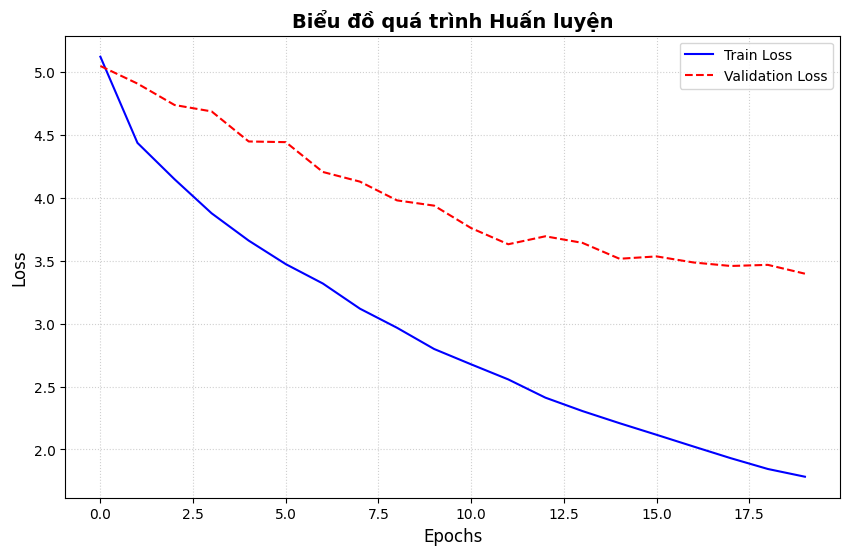


Hoàn tất


In [38]:
import matplotlib.pyplot as plt
import os

#kiểm tra dữ liệu
if 'train_losses' not in globals() or 'valid_losses' not in globals():
  print("chưa có dữ liệu")
else:
  plt.figure(figsize=(10, 6))

  plt.plot(train_losses, label='Train Loss', color='blue', linestyle='-')
  plt.plot(valid_losses, label='Validation Loss', color='red', linestyle='--')

  plt.xlabel('Epochs', fontsize=12)
  plt.ylabel('Loss', fontsize=12)
  plt.title('Biểu đồ quá trình Huấn luyện', fontsize=14, fontweight='bold')
  plt.legend()
  plt.grid(True, linestyle=':', alpha=0.6)

  if 'data_folder' in globals():
    img_path = os.path.join(data_folder, 'loss.png')
    plt.savefig(img_path)
    print(f"Đã lưu ảnh biểu đồ vào: {img_path}")

  plt.show()

  print("\nHoàn tất")

In [41]:
import spacy
import torch
import os

#hàm dịch
def translate(sentence, src_vocab, trg_vocab, model, device, max_len=50):
    model.eval()
    if isinstance(sentence, str):
        #Tokenize nếu chưa có spacy
        tokens = [token.text.lower() for token in spacy_en(sentence)]
    else:
        tokens = [token.lower() for token in sentence]

    src_indexes = [src_vocab['<sos>']] + [src_vocab[token] if token in src_vocab else src_vocab['<unk>'] for token in tokens] + [src_vocab['<eos>']]
    src_tensor = torch.LongTensor(src_indexes).unsqueeze(1).to(device)

    with torch.no_grad():
        hidden, cell = model.encoder(src_tensor)

    trg_indexes = [trg_vocab['<sos>']]
    for i in range(max_len):
        trg_tensor = torch.LongTensor([trg_indexes[-1]]).to(device)
        with torch.no_grad():
            output, hidden, cell = model.decoder(trg_tensor, hidden, cell)
        pred_token = output.argmax(1).item()
        trg_indexes.append(pred_token)
        if pred_token == trg_vocab['<eos>']: break

    trg_tokens = [trg_vocab.lookup_token(i) for i in trg_indexes]
    return trg_tokens[1:-1]

# Load lại model tốt nhất
if os.path.exists(save_path):
    model.load_state_dict(torch.load(save_path, map_location=DEVICE))
    print(f"Đã load model từ: {save_path}\n")

#chạy thử nghiệm
print("Kết quả chạy thử nghiệm:")
sentences = ["A man in an orange hat starring at something.", "A man is eating a pizza.", "Two men are playing soccer.", "Black dog running on the grass."]
for sent in sentences:
    try:
        trans = translate(sent, vocab_en, vocab_fr, model, DEVICE)
        print(f"- Câu tiếng Anh: {sent}")
        print(f"- Câu tiếng Anh sau khi dịch sang tiếng Pháp: {' '.join(trans)}")
        print("\n")
    except Exception as e:
        print(f"Lỗi: {e}")

print("\nHoàn tất")

Đã load model từ: /content/drive/MyDrive/NLP/models/best_model.pth

Kết quả chạy thử nghiệm:
- Câu tiếng Anh: A man in an orange hat starring at something.
- Câu tiếng Anh sau khi dịch sang tiếng Pháp: Un homme avec un chapeau orange regarde quelque chose .


- Câu tiếng Anh: A man is eating a pizza.
- Câu tiếng Anh sau khi dịch sang tiếng Pháp: Un homme lit un magazine .


- Câu tiếng Anh: Two men are playing soccer.
- Câu tiếng Anh sau khi dịch sang tiếng Pháp: trois hommes jouent au football .


- Câu tiếng Anh: Black dog running on the grass.
- Câu tiếng Anh sau khi dịch sang tiếng Pháp: Un chien noir court sur l' herbe .




**Nhận xét:**
- Test ban đầu có thể thấy máy dịch còn sai ngữ pháp và còn lặp từ nhiều

In [45]:
from torchtext.data.metrics import bleu_score
import random
import os
import torch
import csv

#Load model
if os.path.exists(save_path):
    model.load_state_dict(torch.load(save_path, map_location=DEVICE))
    print("Load model thành công!\n")

model.eval()

#Cấu hình file kết quả
if 'data_folder' not in globals():
    data_folder = ''

#tạo folder results nếu chưa có
root_folder = os.path.dirname(data_folder.rstrip('/')) if data_folder else '.'
result_folder = os.path.join(root_folder, 'results')
os.makedirs(result_folder, exist_ok=True)

#luu test và bleu
csv_path = os.path.join(result_folder, 'test_predictions.csv')
score_path = os.path.join(result_folder, 'bleu_score.txt')

#3 ví dụ ngẫu nhiên
print("3 câu ngẫu nhiên từ tập test:")

test_en_path = os.path.join(data_folder, 'test.en')
test_fr_path = os.path.join(data_folder, 'test.fr')

try:
    test_dataset = TranslationDataset(test_en_path, test_fr_path, vocab_en, vocab_fr)
    test_list = list(test_dataset)
except FileNotFoundError:
    print(f"Lỗi: Không tìm thấy file")
    test_list = []

if len(test_list) > 0:
    for i in range(3):
        #ngẫu nhiên
        example = random.choice(test_list)
        src_tensor, trg_tensor = example[0], example[1]

        #chuyển ID sang Từ
        src = [vocab_en.lookup_token(idx) for idx in src_tensor.tolist() if idx not in [SOS_IDX, EOS_IDX, PAD_IDX]]
        trg = [vocab_fr.lookup_token(idx) for idx in trg_tensor.tolist() if idx not in [SOS_IDX, EOS_IDX, PAD_IDX]]
        pred = translate(src, vocab_en, vocab_fr, model, DEVICE)

        print(f"Random {i+1}:")
        print(f"- Câu tiếng Anh: {' '.join(src)}")
        print(f"- Câu tiếng Pháp: {' '.join(trg)}")
        print(f"Output: {' '.join(pred)}")
        print("\n")

#2 câu dài để test lỗi
print("2 câu dài để test chương trình")

hard_sentences = [
    "A very young boy is holding a red ball and running quickly to his mother on the grass.",
    "A man is typing on a laptop in the office."
]

for i, text in enumerate(hard_sentences):
    #tokenize câu tự nhập
    tokens = [token.text.lower() for token in spacy_en.tokenizer(text)]

    pred = translate(tokens, vocab_en, vocab_fr, model, DEVICE)

    print(f"Hard Case {i+1}:")
    print(f"Câu tiếng Anh: {text}")
    print(f"Output: {' '.join(pred)}")
    print("\n")

#tính bleu score và lưu file
print(f"\nTính BLEU score...")
if len(test_list) > 0:
    try:
        trgs = []
        pred_trgs = []

        with open(csv_path, 'w', encoding='utf-8', newline='') as f:
            writer = csv.writer(f)
            writer.writerow(['Input', 'Target', 'Prediction'])

            #Chạy tối đa 1000 câu để tính BLEU
            for i, (src_t, trg_t) in enumerate(test_list):
                if i > 1000: break

                src = [vocab_en.lookup_token(idx) for idx in src_t.tolist() if idx not in [SOS_IDX, EOS_IDX, PAD_IDX]]
                trg = [vocab_fr.lookup_token(idx) for idx in trg_t.tolist() if idx not in [SOS_IDX, EOS_IDX, PAD_IDX]]
                pred = translate(src, vocab_en, vocab_fr, model, DEVICE)

                pred_trgs.append(pred)
                trgs.append([trg])

                writer.writerow([' '.join(src), ' '.join(trg), ' '.join(pred)])

        #tính điểm
        score = bleu_score(pred_trgs, trgs) * 100
        print(f"BLEU Score: {score:.2f}")

        with open(score_path, 'w', encoding='utf-8') as f_score:
            f_score.write(f"BLEU Score: {score:.2f}")

        print(f"Đã lưu điểm số vào: {score_path}")
        print(f"Đã lưu chi tiết các câu dịch vào: {csv_path}")

    except Exception as e:
        print(f"lỗi tính BLEU: {e}")
else:
    print("Không có dữ liệu test")

print("\nHoàn tất")

Load model thành công!

3 câu ngẫu nhiên từ tập test:
Random 1:
- Câu tiếng Anh: People walking about a <unk> campus with palm trees in the background .
- Câu tiếng Pháp: Des gens marchant sur un campus universitaire avec des palmiers en arrière-plan .
Output: Des gens marchant un pont avec avec des arbres en arrière-plan .


Random 2:
- Câu tiếng Anh: A boy in a red suit plays in the water .
- Câu tiếng Pháp: Un garçon en maillot de bain rouge joue dans l' eau .
Output: Un garçon en veste rouge est debout dans l' eau .


Random 3:
- Câu tiếng Anh: A woman reads a book while sitting in a row of red chairs .
- Câu tiếng Pháp: Une femme lit un livre tout en étant assise dans une rangée de fauteuils rouges .
Output: Une femme lit un livre tandis qu' elle est assise dans une pièce de fleurs rouges .


2 câu dài để test chương trình
Hard Case 1:
Câu tiếng Anh: A very young boy is holding a red ball and running quickly to his mother on the grass.
Output: Un jeune garçon tient un petit ballon

**Nhận xét:**
Về cấu trúc ngữ pháp:
Mô hình học tốt cấu trúc câu tiếng Pháp.
- Cả 3 câu dự đoán đều đảm bảo trật tự từ chuẩn (Chủ ngữ - Động từ - Vị ngữ) và chia động từ chính xác.Về độ chính xác từ vựng:
- Ví dụ 1: Xuất hiện token <unk> ở đầu vào do từ gốc là từ hiếm (OOV). Việc thiếu thông tin đầu vào khiến mô hình dự đoán sai ngữ cảnh ("campus" $\rightarrow$ "pont").
- Ví dụ 2: Dịch sai ngữ nghĩa do thiếu dữ liệu ngữ cảnh. Cụm "red suit" (đồ bơi) bị dịch máy móc thành "veste rouge" (áo khoác đỏ).
Hạn chế của kiến trúc LSTM:
- Ở Ví dụ 3, mô hình dịch tốt đoạn đầu nhưng sai lệch hoàn toàn ở cuối câu ("hàng ghế" $\rightarrow$ "phòng đầy hoa"). Đây là hiện tượng mất mát thông tin (vanishing gradient) điển hình khi xử lý câu dài bằng vector ngữ cảnh cố định.
- Kết quả dịch cho thấy mô hình Seq2Seq LSTM gặp hiện tượng mất thông tin khi xử lý các câu dài. Một số thành phần quan trọng trong câu gốc như “red ball”, “to his mother” hay “on the grass” không xuất hiện trong bản dịch, cho thấy mô hình không giữ được đầy đủ ngữ cảnh.
- Ngoài ra bản dịch cũng xuất hiện nhiều cụm từ sai ngữ pháp hoặc vô nghĩa